In [1]:
from src.util import DataLoader, AortaNormalizer, lowpass_filter
from src.visualiazation import plot_pca, plot_random_predictions, plot_relative_error_aorta
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

**Load Data**

In [2]:
data_path = "/data/PulHypStudie_Check_npz_v2/"

In [3]:
data_list = [i for i in range(1, 10)]
data_list # pig 10 -> test pig

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
data_loader = DataLoader(data_path)

X, Y, Pig = data_loader.load_data(data_list)

Data path: /data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
Got a list of 9 pigs to load.
To load ['P_01_PulHyp' 'P_02_PulHyp' 'P_03_PulHyp' 'P_04_PulHyp' 'P_05_PulHyp'
 'P_06_PulHyp' 'P_07_PulHyp' 'P_08_PulHyp' 'P_09_PulHyp']
Loading data from /data/PulHypStudie_Check_npz_v2/P_01_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_02_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_03_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_04_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_05_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_06_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_07_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_08_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_09_PulHyp

Aorta curve min=5.65, max=179.42
Eit.shape=(73536, 64, 1024, 1), Y.shape

In [5]:
aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

**Load VAE**

In [6]:
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    Conv1D,
    ZeroPadding1D,
    Reshape,
    Cropping1D,
)
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss, reconstruction_loss, kl_loss = self.vae_loss(
                data, reconstruction, z_mean, z_log_var
            )

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        loss, reconstruction_loss, kl_loss = self.vae_loss(
            data, reconstruction, z_mean, z_log_var
        )

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        mse_loss_fn = MeanSquaredError()
        input_dim = 1024
        reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss


# The encoder model
def encoder_model(
    input_shape=(1024, 1),
    channels=(5, 10, 20, 30),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
    latent_dim=8,
):
    encoder_inputs = Input(shape=input_shape)
    x = encoder_inputs

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


# The decoder model
def decoder_model(
    latent_dim=8,
    channels=(30, 20, 10, 5),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
):
    latent_inputs = Input(shape=(latent_dim,))
    L = (1024 // np.prod(strides)) * channels[0]
    x = Dense(L, activation="elu")(latent_inputs)
    x = Reshape((1024 // np.prod(strides), channels[0]))(x)

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1DTranspose(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Conv1DTranspose(1, 1, activation="elu", padding="same")(x)
    decoded = x

    return latent_inputs, decoded
    
def build_vae_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=4, max_value=16, step=4)
    beta = hp.Float("beta", min_value=0.1, max_value=2.0, step=0.1)
    #num_channels_choice = hp.Choice("num_channels", values=[5, 10, 20, 30])
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=9, step=1)  
    strides = hp.Int("strides", min_value=2, max_value=4, step=1)
        
    channels=(5, 10, 20, 30)
    # kernel_sizes=(5, 5, 5, 5)
    kernel_sizes = [kernel_size] * 4
    # strides=(4, 4, 4, 4)
    stride_sizes = [strides] * 4

    # Build encoder and decoder
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        channels=channels,
        kernel_size=kernel_sizes,
        strides=stride_sizes,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="Encoder")
    
    decoder_inputs, decoder_outputs = decoder_model(
        channels=channels[::-1],
        kernel_size=kernel_sizes[::-1],
        strides=stride_sizes[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="Decoder")

    encoder.summary()
    decoder.summary()
    vae = VAE(encoder, decoder, beta=beta)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5])))
    return vae

# Instantiate the tuner
tuner = kt.Hyperband(
    build_vae_model,
    objective="loss",
    max_epochs=20,
    factor=2,
    directory="vae_hpt",
    project_name="vae_tuning_1",
)

2024-12-20 09:26:21.618023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 09:26:22.297136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reloading Tuner from vae_hpt/vae_tuning_1/tuner0.json


In [7]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [8]:
vae = tuner.hypermodel.build(best_hps)

2024-12-20 09:26:23.602457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 5)   │         20 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 5)   │         20 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 5)    │         80 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 5)    │         20 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 10)   │        160 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 10)   │         40 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64, 10)    │        310 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 10)    │         40 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 10)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 20)    │        620 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 20)    │         80 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 20)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 16, 20)    │      1,220 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 20)    │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 16, 20)    │          0 │ batch_normalizat

 Total params: 9,426 (36.82 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 16, 30)         │         2,730 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 16, 30)         │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 64, 20)         │         1,820 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 256, 10)        │           610 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 256, 10)        │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,261 (43.99 KB)

 Trainable params: 11,001 (42.97 KB)

 Non-trainable params: 260 (1.02 KB)

In [9]:
# sel_model = "src/weights/vae_model_excl10_0.weights.h5"
# sel_model = "src/weights/vae_model_excl_none_1.weights.h5"
sel_model = "src/weights/vae_model_excl_10_2.weights.h5"

#vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.load_weights(sel_model)
_,_,z = vae.encoder.predict(Y_norm)

/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1734683186.502379    8738 service.cc:145] XLA service 0x77c0f00049c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734683186.502424    8738 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-20 09:26:26.518785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-20 09:26:26.585687: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 117/2298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

I0000 00:00:1734683187.489825    8738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2298/2298 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


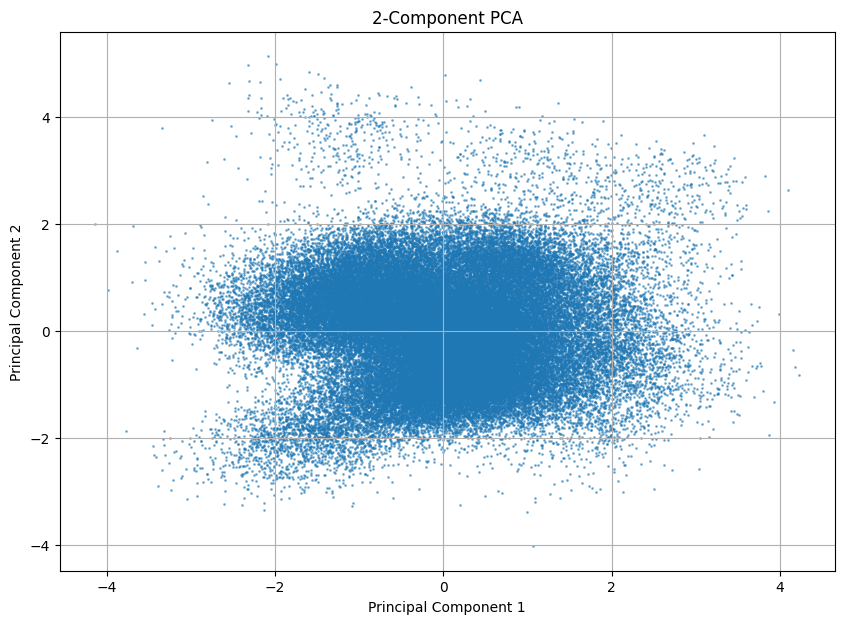

In [10]:
plot_pca(z)

**Train Mapper**

- [KerasTuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [11]:
import keras_tuner as kt
from tensorflow import keras

In [12]:
def build_model(hp):
    latent_dim = 8
    # initialize the sequential model.
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(latent_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    
    return model

In [13]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='hpt_mapper_test10',
    project_name='hpt_mapper_test10'
)


Reloading Tuner from hpt_mapper_test10/hpt_mapper_test10/tuner0.json


In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(X, z, epochs=50,batch_size=20, validation_split=0.2, callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
7                 |7                 |num_layers
10                |10                |units_1
9                 |9                 |kernel_1
4                 |4                 |units_0_1
2                 |2                 |units_1_1
elu               |elu               |activation_1
0.4               |0.4               |dropout_1
10                |10                |units_2
7                 |7                 |kernel_2
2                 |2                 |units_0_2
2                 |2                 |units_1_2
elu               |elu               |activation_2
0                 |0                 |dropout_2
10                |10                |units_3
2                 |2                 |kernel_3
1                 |1                 |units_0_3
2                 |2                 |units_1_3
relu              |relu              |activation_3
0.7               |0.7               |dropout_3
0.001  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 512, 10)    │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 256, 10)     │         4,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 256, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 256, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 256, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 128, 10)     │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 128, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 128, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 64, 2)       │            82 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 64, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 64, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 32, 2)       │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 32, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 16, 2)       │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 16, 2)       │             8 │
│ (BatchNormalization)            │                        │             

 Total params: 8,458 (33.04 KB)

 Trainable params: 8,386 (32.76 KB)

 Non-trainable params: 72 (288.00 B)

None
Epoch 1/2
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.1437 - loss: 0.8506 - val_accuracy: 0.2787 - val_loss: 0.7451
Epoch 2/2
 821/2942 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2660 - loss: 0.7488

In [109]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [110]:
best_hps.values

{'num_layers': 7,
 'units_1': 14,
 'kernel_1': 2,
 'units_0_1': 3,
 'units_1_1': 4,
 'activation_1': 'elu',
 'dropout_1': 0.0,
 'units_2': 6,
 'kernel_2': 9,
 'units_0_2': 1,
 'units_1_2': 3,
 'activation_2': 'relu',
 'dropout_2': 0.0,
 'units_3': 10,
 'kernel_3': 9,
 'units_0_3': 2,
 'units_1_3': 4,
 'activation_3': 'relu',
 'dropout_3': 0.5,
 'learning_rate': 0.01,
 'units_4': 14,
 'kernel_4': 7,
 'units_0_4': 3,
 'units_1_4': 3,
 'activation_4': 'elu',
 'dropout_4': 0.5,
 'units_5': 14,
 'kernel_5': 7,
 'units_0_5': 1,
 'units_1_5': 2,
 'activation_5': 'tanh',
 'dropout_5': 0.4,
 'units_6': 10,
 'kernel_6': 2,
 'units_0_6': 2,
 'units_1_6': 3,
 'activation_6': 'elu',
 'dropout_6': 0.4,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0160'}

**Load Best Model**

In [111]:
model = tuner.hypermodel.build(best_hps)

Init layer i=1
Init layer i=2
Init layer i=3
Init layer i=4
Init layer i=5
Init layer i=6


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 22, 256, 14)    │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 22, 256, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 22, 256, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 22, 256, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 22, 86, 6)      │         6,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 22, 86, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 22, 86, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 22, 86, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 11, 22, 10)     │         4,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 11, 22, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 11, 22, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 11, 22, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 4, 8, 14)       │         6,874 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 4, 8, 14)       │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 4, 8, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 4, 8, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 4, 4, 14)       │         9,618 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 4, 4, 14)       │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_80 (Activation)      │ (None, 4, 4, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 4, 4, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 2, 2, 10)       │           570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 2, 2, 10)       │            40 │
│ (BatchNormalization)            │                        │             

 Total params: 29,412 (114.89 KB)

 Trainable params: 29,276 (114.36 KB)

 Non-trainable params: 136 (544.00 B)

None


In [113]:
X_train, X_valid, z_train, z_valid = train_test_split(X, z, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, z_train.shape, z_valid.shape)

(58828, 64, 1024, 1) (14708, 64, 1024, 1) (58828, 8) (14708, 8)


In [114]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(
    X_train,
    z_train,
    epochs=100,
    batch_size=32,
    # callbacks=[es],
    validation_data=(X_valid,z_valid)
)

Epoch 1/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.2593 - loss: 0.7649 - val_accuracy: 0.4281 - val_loss: 0.6210
Epoch 2/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3928 - loss: 0.6543 - val_accuracy: 0.4497 - val_loss: 0.6012
Epoch 3/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4085 - loss: 0.6434 - val_accuracy: 0.4547 - val_loss: 0.5871
Epoch 4/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4106 - loss: 0.6367 - val_accuracy: 0.4559 - val_loss: 0.5986
Epoch 5/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4192 - loss: 0.6316 - val_accuracy: 0.4658 - val_loss: 0.5731
Epoch 6/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4202 - loss: 0.6268 - val_accuracy: 0.4753 - val_loss: 0.5754
Epoch 7/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4236 - loss: 0.6237 - val_accuracy: 0.4611 - val_loss: 0.5853
Epoch 8/100
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4255 -

In [144]:
model.save_weights("src/weights/mapper_model_1.weights.h5")
np.savez("src/weights/mapper_model_1_history.npz", history=history)

**Test model**

In [130]:
model.evaluate(X,z)

2298/2298 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5226 - loss: 0.5366


[0.536194384098053, 0.5215268731117249]

In [167]:
X_test, Y_t, _ = data_loader.load_data(10,shuffle=False)

aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y_t)
Y_true = Y_t[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

To load ['P_10_PulHyp']
Loading data from /data/PulHypStudie_Check_npz_v2/P_10_PulHyp

Aorta curve min=45.03, max=139.87
Eit.shape=(6282, 64, 1024, 1), Y.shape=(6282, 1024, 1)


In [168]:
# predict with trained model
z_pred = model.predict(X_test)
Y_pred = vae.decoder.predict(z_pred)
Y_pred = aorta_normalizer.normalize_inverse(Y_pred)[:,:,0]

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Pearson correlation coefficient mean 0.973306310054353
MAE 8.03085313672453
MSE 107.37568223902257
Pearson number 0.973306310054353


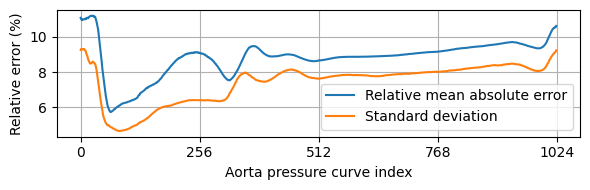

(8.03085313672453, 107.37568223902257, 0.973306310054353)

In [221]:
rel_err_config = {
    "std" : True,
    "var" : False,
    "mean" : True,
    "s_name" : "images/result_1.png",
}

plot_relative_error_aorta(Y_true,Y_pred,**rel_err_config)

Selected prediction 3194.


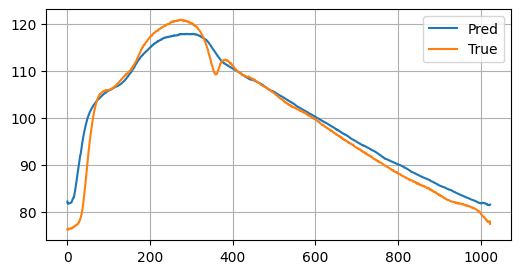

Selected prediction 2203.


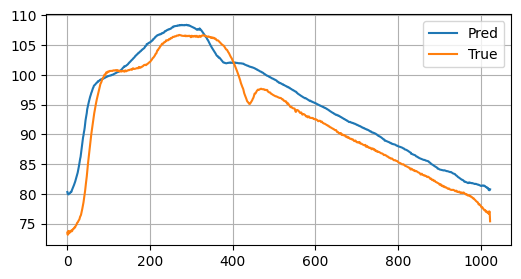

Selected prediction 6210.


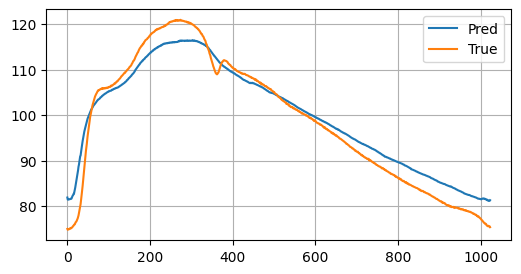

Selected prediction 1812.


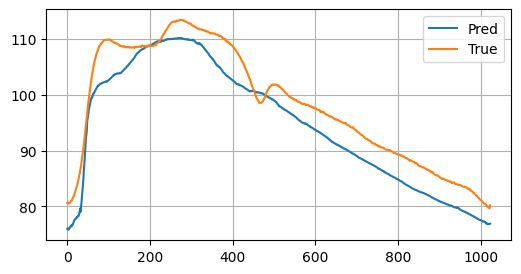

Selected prediction 2761.


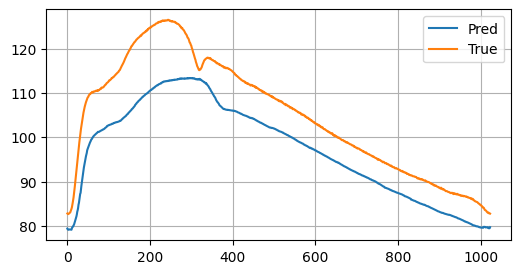

Selected prediction 87.


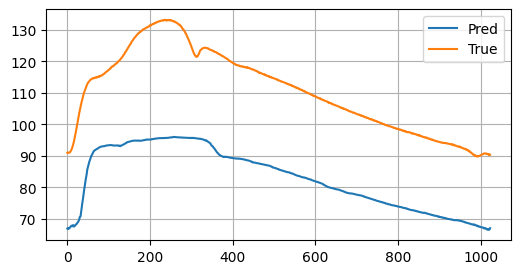

Selected prediction 5738.


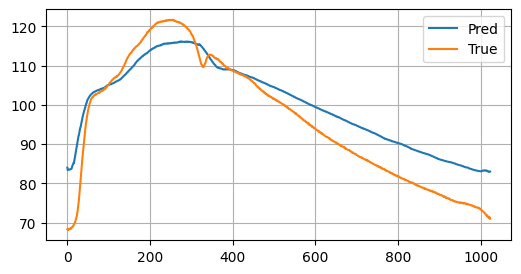

Selected prediction 5257.


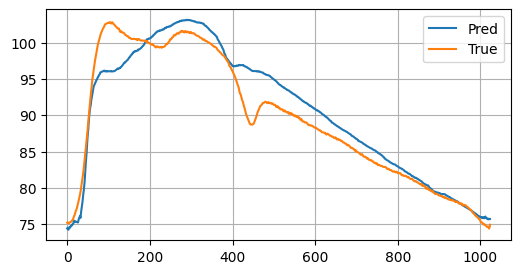

Selected prediction 1363.


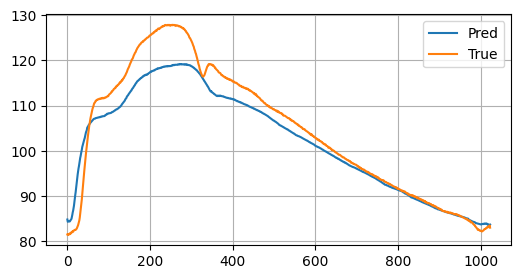

Selected prediction 3403.


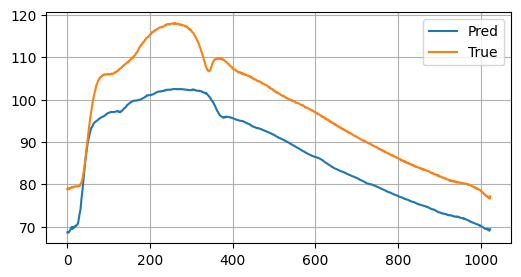

In [146]:
plot_random_predictions(Y_true,Y_pred,n=10)

In [147]:
from src.LaTeX_export import output_err_for_LaTeX,output_curve_for_LaTeX

In [148]:
output_err_for_LaTeX(Y_true, Y_pred,f_name = "err_serious_result_1.csv")

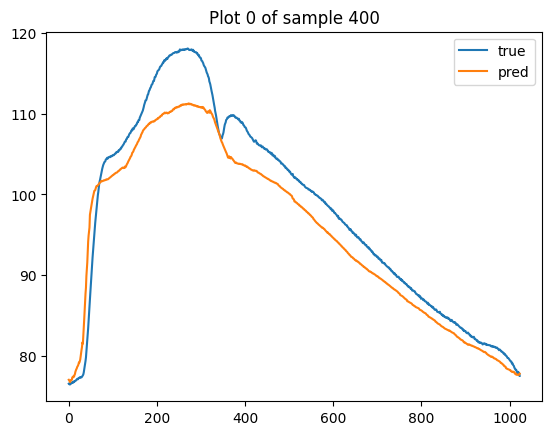

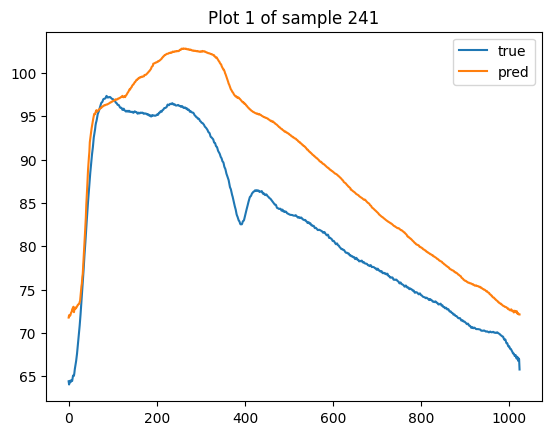

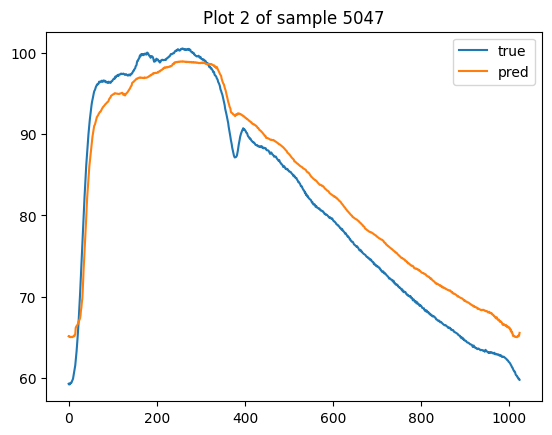

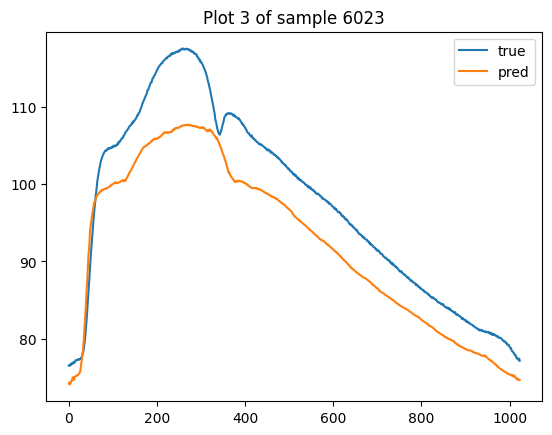

In [160]:
output_curve_for_LaTeX(Y_true, Y_pred,f_name = "curve_serious_result_1.csv")

In [150]:
Y_true.shape

(6282, 1024)

In [151]:
DAP = np.min(Y_true,axis=1)-np.min(Y_pred,axis=1)
SAP = np.max(Y_true,axis=1)-np.max(Y_pred,axis=1)
MAP = np.mean(Y_true,axis=1)-np.mean(Y_pred,axis=1)

In [152]:
import pandas as pd
import seaborn as sns

In [153]:
dd = {"DAP": DAP, "SAP":SAP, "MAP": MAP}
DF = pd.DataFrame(dd)

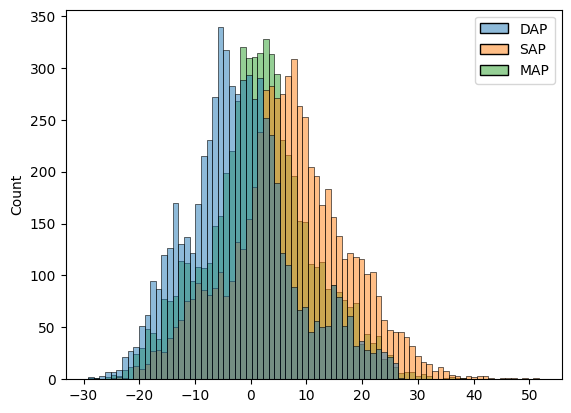

In [154]:
sns.histplot(DF)
plt.savefig("hist_DapSapMap.png")

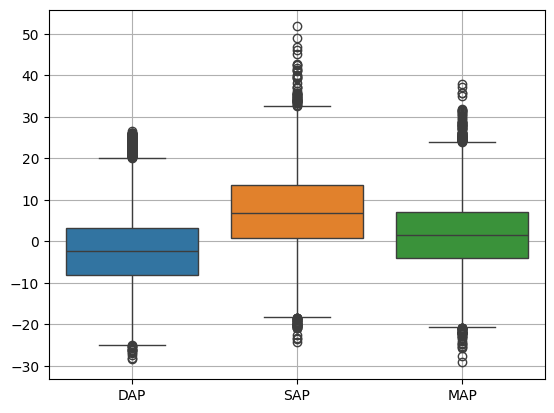

In [143]:
sns.boxplot(DF)
plt.grid()
plt.savefig("box_DapSapMap.png")

**Value over time**

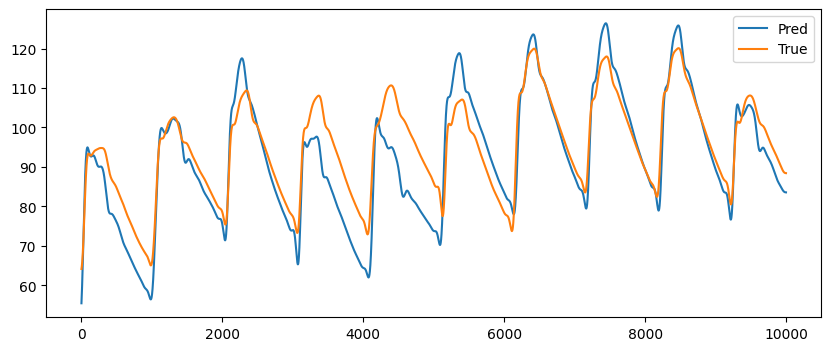

In [211]:
plt.figure(figsize=(10,4))
plt.plot(lowpass_filter(np.concatenate(Y_true)[:10_000]), label="Pred")
plt.plot(lowpass_filter(np.concatenate(Y_pred)[:10_000]), label="True")
plt.legend()

In [224]:
from plotLaTeX import LinePlot

In [225]:
Lplt = LinePlot()

In [226]:
Lplt.add_yvals(lowpass_filter(np.concatenate(Y_true)[:1024*9]), y_name="True")
Lplt.add_yvals(lowpass_filter(np.concatenate(Y_pred)[:1024*9]), y_name="Pred")

Added True with 9216 entries.
Current data stack:
        True
0  55.451587
1  55.854988
2  56.275132
3  56.711925
4  57.165234
Added Pred with 9216 entries.
Current data stack:
        True       Pred
0  55.451587  64.144673
1  55.854988  64.248524
2  56.275132  64.363383
3  56.711925  64.489532
4  57.165234  64.627231


In [227]:
Lplt.export(f_name="curve_results.csv")

**Export**

Current data stack:
        True       Pred  x
0  55.451587  64.144673  0
1  55.854988  64.248524  1
2  56.275132  64.363383  2
3  56.711925  64.489532  3
4  57.165234  64.627231  4

***********
LaTeX code:
***********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel={y-label},
            xlabel={x-label},
            % xtick={0,1,...,10},
            width=7.5cm,
            height=3cm,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
            legend columns = 2,
            legend style={at={(0,1.05)}, legend cell align=left, align=left, draw=white!15!black, mark options={draw=none}, anchor=south west},
         ]
        \addplot[] 
        	table[x=x,y=True,col sep=comma]{curve_results.csv};
        \addlegendentry{True};
        \addplot[] 
        	table[x=x,y=Pred,col sep=comma]{curve_res